# Análisis de datos de un test de 10km
## Tres corredores:
### Atleta A: Jaime Moyano (34:17 PB10k)
### Atleta B: Gabriel Rueda (34:27 PB10k)
### Atleta C: Marco Vidoz (35:30 PB10K)

Prueba realizada sobre el circuito de costanera, Bariloche Río Negro.
Circuito con subidas y bajadas (+50m)

Objetivo: 
Estimar la vel aeróbica max de c/u.
Cuantificar el estado actual actual de c/u.

El acuerdo inicial fue correr a 3:40 los primeros 5km y luego la segunda mitad c/u a lo que da.
Resultado de Tiempos: 36:35 (A), 35:48(B), 35:48(C)

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
v12 = 3.75 #vel para convertir a km/h
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts    
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def f_correct(y, i1,i2,y2):
    #Corrige los datos en el array y entre los indices i1 e i2 de acuerdo o proporcional a y2.
    #Esta función se utiliza para corregir puntos cuando el reloj pierde señal o tiene outliers, speaks o missing data
    z =np.copy(y) 
    n = np.linspace(0, i2-i1,len(y[i1:i2]))
    h2 = y[i2]
    h1 = y[i1]
    y2 = y2 - np.mean(y2[i1:i2])
    z[i1:i2] = (h2-h1)/(i2-i1)*n +h1 + y2[i1:i2]
    return z

In [43]:
#Datos Atleta A     
var = ["grade_adjusted_speed","velocity_smooth","cadence","distance","heartrate","time"] #Parámetros a analizar

f = open("gpx_moyano.txt", "r")
data = f.readline()
A = {} #diccionario con las variables y los indices importantes
#la clave es el nombre de la variable en str

for k in var:
    #print(k)
    i = data.index(k)
    A[k] = [i,len(k),data.index('[',i),data.index(']',i)]
    
data_A = pd.DataFrame()
j=0
for k in A: 
    l = []
    l = [float(i) for i in data[A[k][2]+1:A[k][3]].split(',')]
    data_A[k] = np.array(l[0:2150]) #datos de jaime hasta 2150
    j+= 1    
    
data_A["distance"] = data_A["distance"]/1000 #Cambio de metros a kilometros 
data_A["cadence"] = data_A["cadence"]*2 #el archivo tiene en vuelta (2 pasos x vuelta).  
data_A["velocity_smooth"] = data_A["velocity_smooth"]*v12  

In [44]:
#Datos Altleta B
f = open("gpx_rueda.txt", "r")
data = f.readline()
dire = {} #diccionario con las variables y los indices importantes
#la clave es el nombre de la variable en str
for k in var:
    i = data.index(k)
    dire[k] = [i,len(k),data.index('[',i),data.index(']',i)]   

data_B = pd.DataFrame() #data frame donde se almacenan los datos con clave y valor
j=0
for k in dire: 
    l = []
    l = [float(i) for i in data[dire[k][2]+1:dire[k][3]].split(',')]
    data_B[k] = np.array(l)
    j += 1

 
#Edición de parametros 
data_B["distance"] = data_B["distance"]/1000 #de metros a kilometros 
data_B["cadence"] = data_B["cadence"]*2 #el archivo tiene en vuelta (2 pasos x vuelta.  
data_B["velocity_smooth"] = data_B["velocity_smooth"]*v12 
#El heart rate perdio señal, se corrije proporcional a Velocidad.
#El reloj del corredor C adquirió mal la frecuencia cardiacia en los indices 810-94 y 1230-1244
heartrate = f_correct(np.array(data_B["heartrate"]),200,560,np.array(data_B["velocity_smooth"]))
heartrate = f_correct(heartrate,810,904,np.array(data_B["velocity_smooth"]))
heartrate = f_correct(heartrate,1230,1244,np.array(data_B["velocity_smooth"]))
#Se vuelve a almacenar en el data frame original
data_B["heartrate"] = heartrate

In [13]:
#Datos atleta C
f2 = open("gpx_vidoz.txt", "r")
data = f2.readline()
dire = {} #diccionario con las variables y los indices importantes
#la clave es el nombre de la variable en str
for k in var:
    #print(k)
    i = data.index(k)
    dire[k] = [i,len(k),data.index('[',i),data.index(']',i)]
    
data_C = pd.DataFrame()
j=0
for k in dire: 
    l = []
    l = [float(i) for i in data[dire[k][2]+1:dire[k][3]].split(',')]
    data_C[k] = np.array(l)
    j+= 1    

#Edición de archivos
data_C["distance"] = data_C["distance"]/1680 #de metros a kilometros
 
data_C["cadence"] = np.array(data_C["cadence"]*2) #el archivo tiene en vuelta (2 pasos x vuelta.  
data_C["velocity_smooth"] = data_C["velocity_smooth"]*v12 
   #Se vuelve a almacenar en el data frame original
v_corr = f_correct(np.array(data_C["velocity_smooth"]),450,655,1/180*np.array(data_C["cadence"]))
v_corr = f_correct(v_corr,1750,2100,1/180*np.array(data_C["cadence"]))
v_corr = f_correct(v_corr,3100,3600,1/180*np.array(data_C["cadence"]))
data_C["velocity_smooth"] = v_corr
   
#El heart rate perdio señal, se corrije proporcional a Velocidad
heartrate = np.array(data_C["heartrate"]) #,200,560,np.array(data_1["velocity_smooth"]))
heartrate[0:1200] =heartrate[0:1200]-(np.mean(heartrate[0:1200])-np.mean(heartrate[1200:1700])) 
heartrate = f_correct(heartrate,500,660,np.array(data_C["velocity_smooth"]))
heartrate = f_correct(heartrate,1700,2150,np.array(data_C["velocity_smooth"]))
heartrate = f_correct(heartrate,2950,3600,np.array(data_C["velocity_smooth"]))
#Se vuelve a almacenar en el data frame original
data_C["heartrate"] = heartrate
      
#Se vuelve a almacenar en el data frame original
c_corr = f_correct(np.array(data_C["cadence"]),400,700,np.array(data_C["velocity_smooth"]))
c_corr = f_correct(c_corr,1750,2100,1/180*np.array(data_C["velocity_smooth"]))
c_corr = f_correct(c_corr,3100,3600,1/180*np.array(data_C["velocity_smooth"]))
data_C["cadence"] = c_corr      

##  Se compara la velocidad vs distancia de los tres atletas
En el siguiente gráfico se muestra la velocidad de los tres atletas en función de la distancia.
El corredor A y B corrieron de forma muy similar y progresiva.

El atleta C tiene una mayor dispersión con respecto a su velocidad media, en los segundos 5km  tuvo una velocidad promedio marcadamente menor que el promedio de A y B.

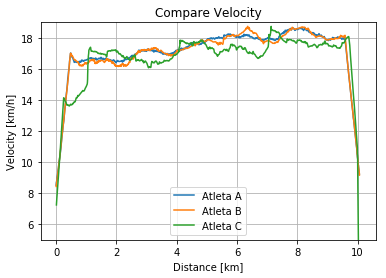

In [46]:
plt.figure(1)
N1 = 200
plt.title("Compare Velocity")
plt.plot(data_A["distance"],smooth(data_A["velocity_smooth"],N1),label="Atleta A")
plt.plot(data_B["distance"],smooth(data_B["velocity_smooth"],N1),label="Atleta B")
plt.plot(data_C["distance"],smooth(data_C["velocity_smooth"],N1),label="Atleta C")

plt.xlabel('Distance [km]')
plt.ylabel("Velocity [km/h]")
plt.legend()
plt.grid()
plt.ylim((5,19))
plt.show()


## Cálculo de la VAM a partir del test

Hay varias formas de estimar la VAM en función de una prueba de 10k.

## Opción 1
Tomar de forma directa el tiempo de tu tiempo actual en 10k y luego usar las tabulaciones entre tiempos de 10k o 5k vs VAM

En la siguiente ref hay una relación.

https://www.athlete-endurance.com/training-network/es/running/vam-y-vo2max/velocidad-aerobica-maxima-vam.html

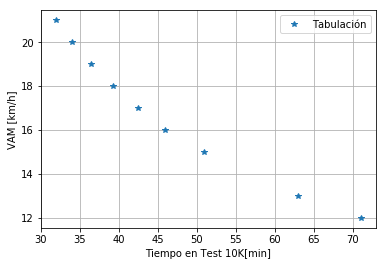

In [30]:
VAM = [12, 13, 15,16, 17, 18, 19, 20, 21]
T_10K = [71, 63, 51, 46, 42.5,39.33, 36.5,34,32]

plt.figure()
plt.plot(T_10K, VAM,'*',label ="Tabulación")
plt.xlabel('Tiempo en Test 10K[min]')
plt.ylabel("VAM [km/h]")
plt.legend()
plt.grid()
plt.show()  

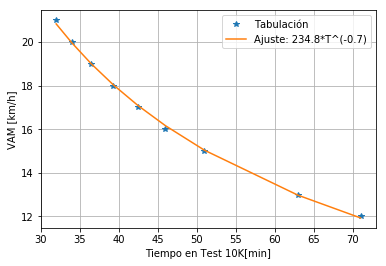

In [31]:
#Se ajusto la curva con una potencia con una tel tipo a*x^2
def VAM_test10(t):
    #Tiempo en minutos
    #Es la regresión de la anterior tabla, ingresa tu tiempo en 10 y devuelve la VAM
    return(234.88*(t**(-0.699)))
           
#fit1 = np.array
fit1 = VAM_test10(np.array(T_10K))
plt.figure()
plt.plot(T_10K, VAM,'*',label ="Tabulación")
plt.plot(T_10K, fit1,label ="Ajuste: 234.8*T^(-0.7)")
plt.xlabel('Tiempo en Test 10K[min]')
plt.ylabel("VAM [km/h]")
plt.legend()
plt.grid()
plt.show()  

In [54]:
atl = ["Atleta A","Atleta B","Atleta C"]
VAM_1 = [VAM_test10(36+35/60),VAM_test10(35+48/60),VAM_test10(35+48/60)]

for j in range(3):
    print("El",atl[j],"posee una VAM = ", round(VAM_1[j],1),"km/h")

El Atleta A posee una VAM =  19.0 km/h
El Atleta B posee una VAM =  19.3 km/h
El Atleta C posee una VAM =  19.3 km/h


## OPCIÓN 2

Una segunda opción que nos daría una VAM más eleveda sería buscar la velocidad media de los últimos 5k, y asumir que a ese ritmo podrían haber corrido los 10k, recordemos que el test se acordó correr los primeros 5k (la ida) a una velocidad cercana a 3:40 y luego los segundos 5k si fueron a un ritmo personal máximo de c/u.

- Según algunas lecturas uno podría correr 10k al 90% de la VAM.
- Lo anterior podría ser válido ya que el circuito elegido no era llano, ni limpio, fue por al lado de una avenida, con varias lomadas.


In [57]:
V05_A = round(np.mean(data_A["velocity_smooth"][int(len(data_A["velocity_smooth"])/2):-100]),2)
V05_B = round(np.mean(data_B["velocity_smooth"][int(len(data_B["velocity_smooth"])/2):-100]),2)
V05_C = round(np.mean(data_C["velocity_smooth"][int(len(data_C["velocity_smooth"])/2):-400]),2)
V05 = [V05_A,V05_B,V05_C]
VAM_2 =[] #lA NUEVA VAM
for V in V05:
    print("El",atl[j],"corrió los últimos 5k a",round(V,1),"km/h")
    VAM_2.append(VAM_test10(10*60/V))

  

El Atleta C corrió los últimos 5k a 18.1 km/h
El Atleta C corrió los últimos 5k a 18.1 km/h
El Atleta C corrió los últimos 5k a 17.2 km/h
[20.32523792275649, 20.32523792275649, 19.645263575183098]


In [81]:
#En base a las dos opciones de cálculo de VAM podemos tomar el promedio de ambas y su barra de error como la diferencia.

VAM = pd.DataFrame()
y = []
e = []
for j in range(3):
    y.append((VAM_1[j]+VAM_2[j])/2)
    e.append((VAM_2[j]-VAM_1[j])/2)
    VAM[atl[j]] = [y[j],e[j]]

VAM.head()

,Atleta A,Atleta B,Atleta C
0,19.648573,19.793185,19.453198
1,0.676665,0.532053,0.192066


In [99]:
names = ["Atleta A", "Atleta B","Atleta C"]
#VAM = [3:12, 3:03,3:08] #vel de 2k de c/u

V_vam = y#vam promedio

#V_10K_Personal Best = [3:33, 3:26,3:27] (Pista2019, CIpolletti2019, Velodromo2019)
V_10k = 20-np.array([26,27,33])/12
FC10k_avg = [177,172,184]
FC10k_max = [193,190,195]
P_Best = pd.DataFrame()
P_Best["parametros"] = ["V_vam","V_10K", "FC_Average_10k","FC_Max_10k"]
j = 0
for i in names:
    P_Best[i] = np.array([round(V_vam[j],2),round(V_10k[j],2),int(FC10k_avg[j]),int(FC10k_max[j])])
    j +=1

P_Best.head()

,parametros,Atleta A,Atleta B,Atleta C
0,V_vam,19.65,19.79,19.45
1,V_10K,17.83,17.75,17.25
2,FC_Average_10k,177.00,172.00,184.00
3,FC_Max_10k,193.00,190.00,195.00


# Datos Personales:
- V_vam: Velocidad estimada [km/h]---> ()
- V_10K: Marca personal en 10 K [km/h], todas en 2019
- FC_Average_10k: Frecuencia promedio cuando realizaron su Personal best de 10k
- FC_Max_10k: Frecuencia Máxima cuando realizaron su Personal best de 10k


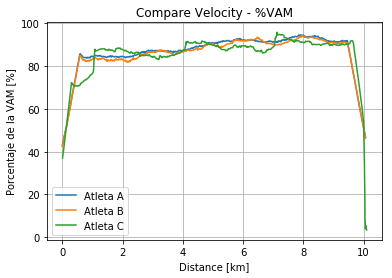

In [105]:
V_VAM_A = np.array(100 - (P_Best["Atleta A"][0]-np.array(data_A["velocity_smooth"]))/P_Best["Atleta A"][0]*100)
V_VAM_B = np.array(100 - (P_Best["Atleta B"][0]-np.array(data_B["velocity_smooth"]))/P_Best["Atleta B"][0]*100)
V_VAM_C = np.array(100 - (P_Best["Atleta C"][0]-np.array(data_C["velocity_smooth"]))/P_Best["Atleta C"][0]*100)

plt.figure(2)
N1 = 250
plt.title("Compare Velocity - %VAM")
ax1 = plt.plot(data_A["distance"],smooth(V_VAM_A,N1),label=names[0])
plt.plot(data_B["distance"],smooth(V_VAM_B,N1),label=names[1])
plt.plot(data_C["distance"],smooth(V_VAM_C,N1),label=names[2])
plt.xlabel('Distance [km]')
plt.ylabel("Porcentaje de la VAM [%]")
plt.legend()
plt.grid()
plt.show()

# Comparación en los primeros 5k:
 Cuánto se exigió c/u con respecto a su VAM

In [106]:
V05_A = round(np.mean(V_VAM_A[0:int(len(V_VAM_A)/2)]),2)
V05_B = round(np.mean(V_VAM_B[0:int(len(V_VAM_B)/2)]),2)
V05_C = round(np.mean(V_VAM_C[0:int(len(V_VAM_C)/2)]),2)

print("El atleta A corrió los primeros 5K a un ", V05_A,"% de su VAM")
print("El atleta B corrió los primeros 5K a un ", V05_B,"% de su VAM")
print("El atleta C corrió los primeros 5K a un ", V05_C,"% de su VAM")


El atleta A corrió los primeros 5K a un  86.14 % de su VAM
El atleta B corrió los primeros 5K a un  85.03 % de su VAM
El atleta C corrió los primeros 5K a un  84.61 % de su VAM


# Comparación en los segundos 5k:
Cuánto se exigió c/u con respecto a su VAM

In [107]:
V05_A = round(np.mean(V_VAM_A[int(len(V_VAM_A)/2):-1]),2)
V05_B = round(np.mean(V_VAM_B[int(len(V_VAM_B)/2):-1]),2)
V05_C = round(np.mean(V_VAM_C[int(len(V_VAM_C)/2):-1]),2)

print("El atleta A corrió los segundos 5K a un ", V05_A,"% de su VAM")
print("El atleta B corrió los segundos 5K a un ", V05_B,"% de su VAM")
print("El atleta C corrió los segundos 5K a un ", V05_C,"% de su VAM")

El atleta A corrió los segundos 5K a un  92.22 % de su VAM
El atleta B corrió los segundos 5K a un  91.5 % de su VAM
El atleta C corrió los segundos 5K a un  75.39 % de su VAM


# Comparación en Frecuencia Cardiaca
Frecuencia promedio cuando realizaron su Personal best de 10k 

Vidoz: 184

Moyano: 177

Rueda: 172

Frecuencia Máxima medida 

Vidoz: 195

Moyano: 193

Rueda: 191

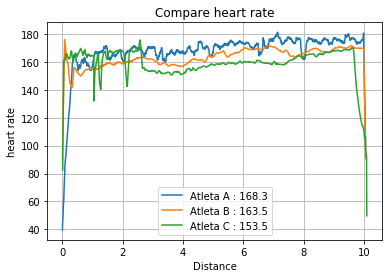

In [111]:
## Se compara la frec cardiaca de los tres atletas
plt.figure(2)
N2 = 30
plt.title("Compare heart rate")
plt.plot(data_A["distance"],smooth(data_A["heartrate"],N2),label=names[0]+" : "+str(round(np.mean(data_A["heartrate"]),1)))
plt.plot(data_B["distance"],smooth(data_B["heartrate"],N2),label=names[1]+" : "+str(round(np.mean(data_B["heartrate"]),1)))
plt.plot(data_C["distance"],smooth(data_C["heartrate"],N2),label=names[2]+" : "+str(round(np.mean(data_C["heartrate"]),1)))
plt.xlabel('Distance')
plt.ylabel("heart rate")
plt.legend()
plt.grid()
plt.show()

Creo que el sensor del Atleta C (Vidoz midió mal la señal de heart rate en los primeros 2km. Parece demasiado eleveda.
De todos modos strava, tiene otro valor en función de la distancia, como que está más arriba

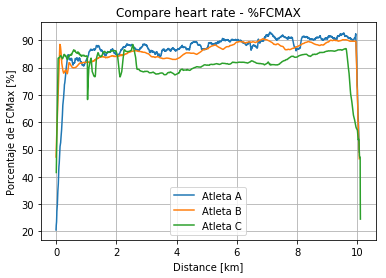

In [114]:
V_VAM_A = np.array(100 - (P_Best[names[0]][3]-np.array(data_A["heartrate"]))/P_Best[names[0]][3]*100)
V_VAM_B = np.array(100 - (P_Best[names[1]][3]-np.array(data_B["heartrate"]))/P_Best[names[0]][3]*100)
V_VAM_C = np.array(100 - (P_Best[names[2]][3]-np.array(data_C["heartrate"]))/P_Best[names[0]][3]*100)

 
plt.figure(2)
N1 = 50
plt.title("Compare heart rate - %FCMAX")
ax1 = plt.plot(data_A["distance"],smooth(V_VAM_A,N1),label=names[0])
plt.plot(data_B["distance"],smooth(V_VAM_B,N1),label=names[1])
plt.plot(data_C["distance"],smooth(V_VAM_C,N1),label=names[2])
plt.xlabel('Distance [km]')
plt.ylabel("Porcentaje de FCMax [%]")
plt.legend()
plt.grid()
#ax1.set_ylim(60,110)
plt.show()

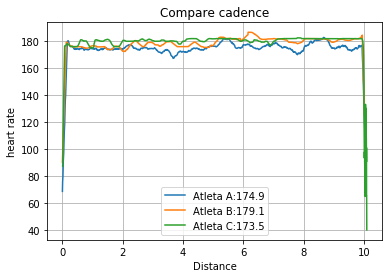

In [117]:
plt.figure(3)
N3=50
plt.title("Compare cadence")
plt.plot(data_A["distance"],smooth(data_A["cadence"],N3),label=names[0]+":"+str(round(np.mean(data_A["cadence"]),1)))
plt.plot(data_B["distance"],smooth(data_B["cadence"],N3),label=names[1]+":"+str(round(np.mean(data_B["cadence"]),1)))
plt.plot(data_C["distance"],smooth(data_C["cadence"],N3),label=names[2]+":"+str(round(np.mean(data_C["cadence"]),1)))
plt.xlabel('Distance')
plt.ylabel("heart rate")
plt.legend()
plt.grid()
plt.show()

